In [1]:
cd ..

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    get_class_weights,
    get_initial_output_bias,
    evaluate_model,
    make_sentence_vectorizer,
    get_3d_quartile_words_count,
    SEED
)
from wordEmbeddingsLayers import (
    navec_word_vectorizer,
    NAVEC_EMBEDDING_DIMENSION,
)

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Word Vectorizer

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
VECTORIZED_SENTENCE_LENTGH = get_3d_quartile_words_count(X_train.flatten())

navec_sentence_vectorizer = make_sentence_vectorizer(
    vectorizer=navec_word_vectorizer,
    pad_sentence_to_n_words=VECTORIZED_SENTENCE_LENTGH
)

In [5]:
X_train = np.array(list(
    map(navec_sentence_vectorizer, X_train.flatten())
))

X_test = np.array(list(
    map(navec_sentence_vectorizer, X_test.flatten())
))

# Build RNN model

In [6]:
from tensorflow.keras import layers, losses

negative_class_amount, pos_class_amount = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    get_initial_output_bias(pos_class_amount, negative_class_amount)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=1,
    restore_best_weights=False
)

model = tf.keras.Sequential([
    layers.Input(shape=(VECTORIZED_SENTENCE_LENTGH, NAVEC_EMBEDDING_DIMENSION,), dtype=tf.float32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    layers.Dropout(rate=0.2, seed=SEED),
    tf.keras.layers.Dense(64, activation='relu'),
    layers.Dense(units=1, bias_initializer=initial_output_bias),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, т.к. на выходе layers.Activation('sigmoid')
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [7]:
epochs = 20
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=2**7,
    validation_split=0.2, # сколько от тестовой выборки отрезать под валидационную
    callbacks=[early_stopping],
    class_weight=get_class_weights(pos_class_amount, negative_class_amount),
)

Epoch 1/20
73/73 [==============================] - 6s 50ms/step - loss: 0.5816 - binary_accuracy: 0.7288 - recall: 0.4877 - precision: 0.5964 - val_loss: 0.3500 - val_binary_accuracy: 0.8673 - val_recall: 0.8945 - val_precision: 0.7533
Epoch 2/20
73/73 [==============================] - 2s 30ms/step - loss: 0.2867 - binary_accuracy: 0.8827 - recall: 0.8881 - precision: 0.7922 - val_loss: 0.2948 - val_binary_accuracy: 0.8803 - val_recall: 0.8802 - val_precision: 0.7860
Epoch 3/20
73/73 [==============================] - 2s 31ms/step - loss: 0.2614 - binary_accuracy: 0.8969 - recall: 0.9038 - precision: 0.8097 - val_loss: 0.3493 - val_binary_accuracy: 0.8565 - val_recall: 0.9271 - val_precision: 0.7214
Epoch 4/20
73/73 [==============================] - 2s 34ms/step - loss: 0.2505 - binary_accuracy: 0.9003 - recall: 0.9284 - precision: 0.8085 - val_loss: 0.2986 - val_binary_accuracy: 0.8877 - val_recall: 0.8646 - val_precision: 0.8107
Epoch 5/20
73/73 [==============================] - 

# Model evaluation

Accuracy: 89.56%
Recall: 94.65%
Precision: 78.32%
F1-score: 85.71% 



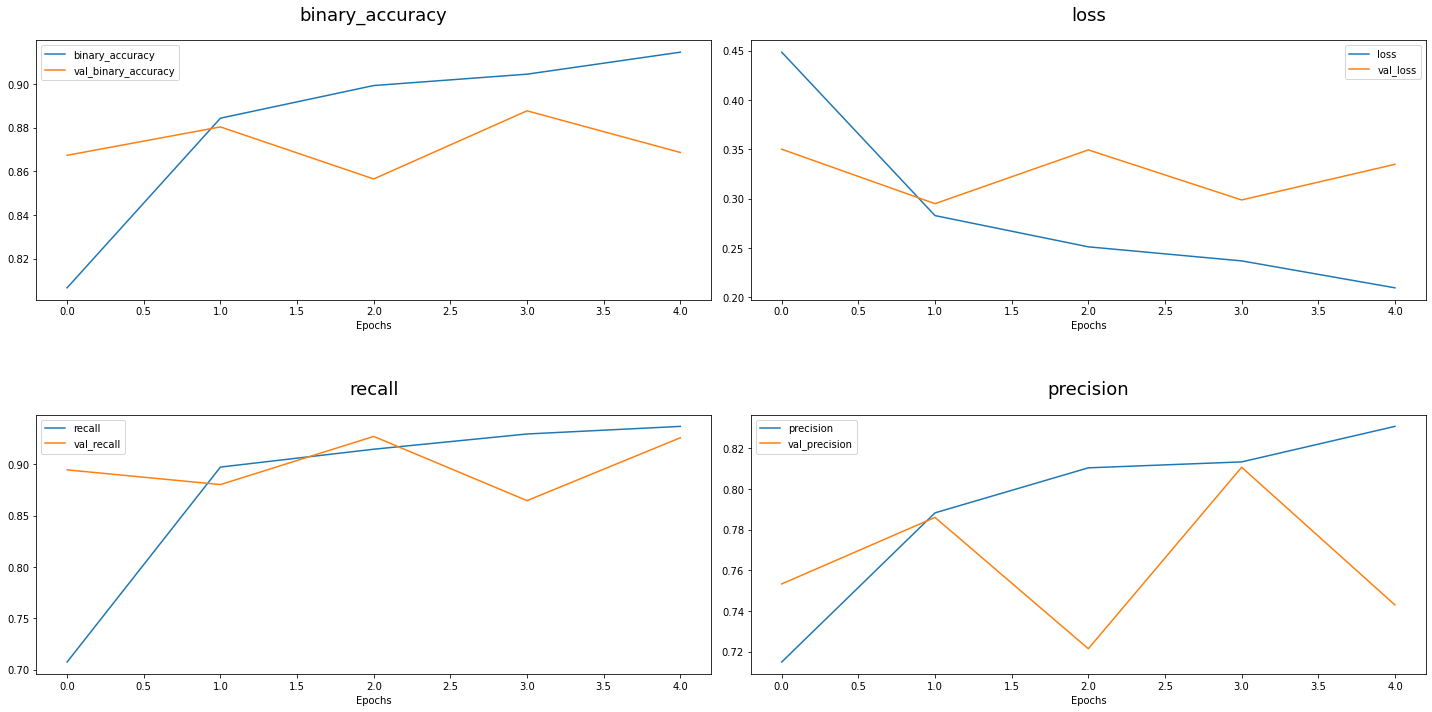

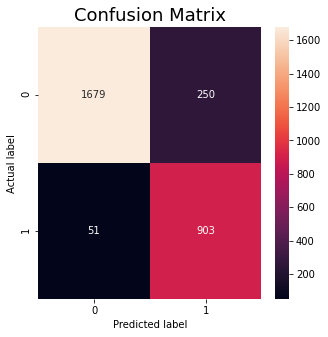

In [8]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)